____
__Universite de Technologie de Troyes__<br/>
__Universidad Tecnologica Nacional Buenos Aires__<br/>
__Machine Learning & Pattern Recognition__<br/>
__Martin Palazzo__<br/>
__Data: expression sequence data from Liver and Renal tumor profiles__<br/>
__Topic: dimensionality reduction via PCA, kernel-PCA, Autoencoder and VAE__
____

In [1]:
# liver 1
# renal 0

### Import libraries

In [2]:
# basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

#sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#tensorflow keras
import keras
from keras.layers import Activation
from tensorflow.keras import layers
from keras.layers.normalization import BatchNormalization
from keras import models
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Dropout
from keras import backend as K


check if we are using GPU or CPU

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7558971287584314642
]


### Import Dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving liver_kidney_expseq.csv to liver_kidney_expseq.csv


In [5]:
#uploaded = files.upload()

In [7]:
data = pd.read_csv('./liver_kidney_expseq.csv', delimiter = ',', index_col=0 )
print('Shape:', data.shape)
data.head()

Shape: (812, 1027)


,0,?,A1BG,A2M,AADAC,ABP1,ACAA1,ACAA2,ACADVL,ACAT1,ACP5,ACSL1,ACSM2A,ACSM2B,ACTA2,ACTB,ACTG1,ACTN4,ACY1,ADH1A,ADH1B,ADH1C,ADH4,ADI1,ADM,AEBP1,AES,AFP,AGR2,AGT,AGXT,AHSG,AIF1L,AKR1A1,AKR1B1,AKR1B10,AKR1C1,AKR1C2,AKR1C3,AKR1C4,...,TUBB2C,TXN,TXNIP,TYROBP,UBB,UBC,UBD,UBL5,UGT1A1,UGT1A4,UGT1A6,UGT1A9,UGT2B15,UGT2B4,UGT2B7,UMOD,UQCRC1,UQCRC2,UQCRH,UQCRQ,USMG5,VAMP8,VCAM1,VDAC1,VEGFA,VIM,VKORC1,VTN,VTRNA1-1,VWF,WDR74,WFDC2,XAGE1D,XBP1,YBX1,YWHAE,YWHAQ,YWHAZ,ZFP36,ZFP36L1
0,0.0,0.000320,1.205316e-06,0.000870,0.000000e+00,0.000136,0.000062,0.000311,0.000478,0.000138,0.000107,0.000222,0.000364,0.000201,0.000777,0.002539,0.001084,0.000233,0.000070,0.000000e+00,2.826390e-07,0.000000e+00,0.000000e+00,0.000121,0.001066,0.000388,0.000246,8.337533e-08,2.792460e-08,0.000091,2.818430e-07,1.733514e-08,0.000048,0.000219,0.000617,4.698390e-08,0.000262,0.000021,0.000148,1.100184e-07,...,0.000096,0.000374,0.000781,0.000220,0.001093,0.002120,0.000385,0.000357,1.687890e-06,1.326139e-07,0.000035,0.000296,2.370085e-07,0.000000e+00,0.000103,9.593786e-08,0.000100,0.000183,0.000074,0.000074,0.000246,0.000235,0.000411,0.000341,0.002579,0.004286,0.000217,1.720146e-07,0.0,0.000298,0.000036,0.000008,0.000000e+00,0.000081,0.000351,0.000532,0.000179,0.000269,0.000443,0.000245
1,0.0,0.000258,1.041018e-06,0.001258,1.137360e-07,0.000106,0.000051,0.000164,0.000271,0.000136,0.000037,0.000286,0.000167,0.000160,0.001161,0.003779,0.002051,0.000252,0.000048,3.426129e-07,1.215082e-05,4.410115e-07,2.253563e-08,0.000080,0.000208,0.000175,0.000327,9.149890e-08,2.542967e-07,0.000052,1.144449e-06,0.000000e+00,0.000013,0.000149,0.000748,2.005947e-06,0.000029,0.000008,0.000361,4.016505e-08,...,0.000180,0.000374,0.000464,0.000249,0.001031,0.001528,0.000093,0.000328,2.607222e-06,1.033913e-07,0.000164,0.000079,2.068509e-08,0.000000e+00,0.000073,0.000000e+00,0.000108,0.000199,0.000253,0.000070,0.000220,0.000103,0.000212,0.000254,0.001225,0.004354,0.000247,1.626847e-07,0.0,0.000298,0.000029,0.000048,0.000000e+00,0.000182,0.000555,0.000547,0.000277,0.000553,0.000328,0.000312
2,0.0,0.000264,5.559443e-07,0.000696,0.000000e+00,0.000631,0.000066,0.000534,0.000367,0.000244,0.000123,0.000208,0.000232,0.000141,0.000262,0.001977,0.001453,0.000225,0.000104,4.961943e-08,4.468265e-06,6.385555e-08,1.141919e-08,0.000114,0.000374,0.000065,0.000261,0.000000e+00,0.000000e+00,0.000180,6.049459e-07,4.819312e-08,0.000020,0.000281,0.000089,0.000000e+00,0.000141,0.000020,0.000378,2.442844e-07,...,0.000153,0.000776,0.000428,0.000190,0.001627,0.001935,0.000235,0.000346,1.792879e-06,1.265033e-07,0.000254,0.000441,1.048124e-08,0.000000e+00,0.000943,2.970525e-08,0.000152,0.000202,0.000315,0.000100,0.000381,0.000390,0.000653,0.000427,0.000727,0.003777,0.000252,1.126681e-06,0.0,0.000206,0.000049,0.000046,0.000000e+00,0.000110,0.000379,0.000645,0.000187,0.000291,0.000113,0.000136
3,0.0,0.000288,1.599123e-06,0.000942,2.499093e-08,0.000087,0.000046,0.000284,0.000283,0.000083,0.000066,0.000189,0.000076,0.000076,0.000372,0.002800,0.001700,0.000242,0.000056,1.280968e-07,6.876787e-06,2.212439e-07,1.587955e-07,0.000117,0.000198,0.000092,0.000325,1.392887e-06,8.867711e-08,0.000073,1.521965e-06,5.565499e-08,0.000042,0.000151,0.000254,5.295259e-04,0.000153,0.000018,0.000281,1.054537e-07,...,0.000113,0.000613,0.000861,0.000233,0.001224,0.001802,0.000417,0.000313,2.388011e-06,3.599584e-07,0.000122,0.000173,1.093908e-07,2.035745e-08,0.000264,0.000000e+00,0.000104,0.000205,0.000088,0.000071,0.000267,0.000252,0.000202,0.000340,0.001565,0.005108,0.000185,9.536935e-08,0.0,0.000515,0.000042,0.000047,5.798708e-07,0.000214,0.000293,0.000500,0.000242,0.000353,0.000165,0.000143
4,0.0,0.000247,2.226037e-06,0.001935,0.000000e+00,0.000249,0.000058,0.000382,0.000224,0.000090,0.000033,0.000178,0.000131,0.000073,0.000552,0.003097,0.001983,0.000370,0.000041,3.047401e-07,1.700954e-05,1.744599e-07,0.000000e+00,0.000124,0.000423,0.000180,0.000357,1.689218e-07,3.518187e-08,0.000016,2.879904e-07,0.000000e+00,0.000027,0.000138,0.000199,1.984058e-0

Perform Train-Test split

In [8]:
xtr00, xte0, ytr0, yte0 = train_test_split(data.iloc[:, 1:], data.iloc[:,0], test_size=0.3, random_state=42)
#ytr = ytr0.sort_values(by = [0])
ytr = ytr0
xtr0 = xtr00.reindex(ytr.index)
ytr = ytr.values
yte = yte0.values
ytr[ytr == 0] = -1
yte[yte == 0] = -1

MinMax Scaler between 0 and 1

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
xtr = pd.DataFrame(scaler.fit_transform(xtr0.values))
xte = pd.DataFrame(scaler.transform(xte0))

In [10]:
xtr.shape

(568, 1026)

## Principal Component Analysis

Implement a PCA of the training data for visualization and exploration

In [11]:
# 
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(xtr)
xtr_pca = pca.transform(xtr)
xte_pca = pca.transform(xte)

In [12]:
# check the cumulative variance within the preserved components
np.sum(pca.explained_variance_ratio_)

0.6008211335334258

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


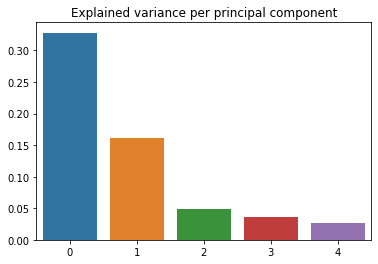

In [13]:
sns.barplot(np.arange(0,5),pca.explained_variance_ratio_)
plt.title('Explained variance per principal component')
plt.show()

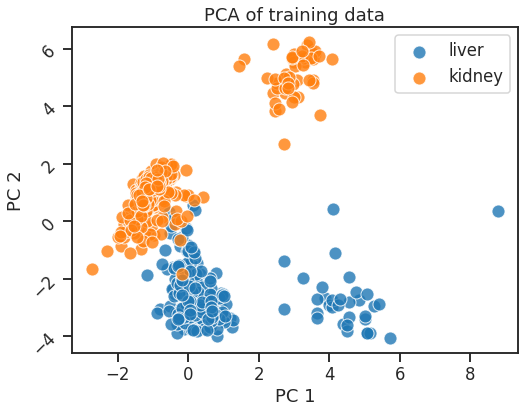

In [14]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot()
sns.scatterplot(x=xtr_pca[(ytr == 1).ravel(),1], y=xtr_pca[(ytr == 1).ravel(),0], alpha = 0.8, s= 170, legend='full', label = 'liver')
sns.scatterplot(x=xtr_pca[(ytr == -1).ravel(),1], y=xtr_pca[(ytr == -1).ravel(),0],alpha = 0.8, s= 170, legend='full', label = 'kidney')
ax1.legend(bbox_to_anchor=(-0.2, 1), loc=2, borderaxespad=0.,framealpha=1, frameon=True)
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (8,6) )
ax1.set_title("PCA of training data")
plt.yticks(rotation=45) 
plt.legend()
plt.show()

# Kernel-PCA

In [15]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=5, kernel='rbf',gamma= 0.001)
xtr_kpca = kpca.fit_transform(xtr)
xte_kpca = kpca.transform(xte)

# Autoencoder
Here an autoencoder function is defined. The architecture can be changed if it is necessary.

In [16]:
def ae_arch_0(encoding_dim, epochs, bachs, l1_reg, l2_reg, lrate, xtr, xte): 
    earlstop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  mode='auto', baseline=None, restore_best_weights=False, verbose=1)
    rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='auto')
    
    ################### Optimizer ###################
    optim = keras.optimizers.Adam(lr=lrate)

    ################### MODEL ARCHITECTURE ###############
    
    # 00) INPUT
    inputdim = Input(shape=(xtr.shape[1],))
    
    # 01) DENSE LAYER
    encode_i = Dense(200, kernel_regularizer=regularizers.l2(l2_reg), activation = 'relu')(inputdim)
    
    # 02) BATCH NORM
    bn_i = BatchNormalization()(encode_i)
    
    # 03) DENSE LAYER
    encode_ii = Dense(100, activation = 'relu')(bn_i)

    latent = Dense(encoding_dim, kernel_regularizer = regularizers.l2(l2_reg), activation = 'relu')(encode_ii)

    # 04) DECODER
    #decode_i = Dense(100, activation = 'relu')(latent)
    decode_ii = Dense(200,activation='relu')(latent)
    
    # 05) DECODER
    decode_iii = Dense(xtr.shape[1],activation='linear')(decode_ii)
    
    # 06) AUTOENCODER
    autoencoder = Model(inputdim, decode_iii)
    encoder = Model(inputdim, latent)
    
    #encoded_input5 = Input(shape=(encoding_dim5,))
    #decoder_layer5 = autoencoder5.layers[-3]
    #decoder5 = Model(x3, decoder_layer5(x3))

    autoencoder.summary()
    #keras.utils.plot_model(autoencoder, show_shapes=True)
    compression_factor = float(np.shape(xtr)[1]) / encoding_dim
    print("Compression factor: %s" % compression_factor)
    
    ################## COMPILE AND FIT MODEL #############
    autoencoder.compile(optimizer=optim, loss='mse')
    autoencoder.fit(xtr, xtr,epochs=epochs, batch_size=bachs,  shuffle=True,  validation_data=(xte, xte), callbacks = [earlstop, rlrop])
    
    histval = autoencoder.history.history['val_loss']
    histtra = autoencoder.history.history['loss']
    
    return encoder, histtra, histval

Train an autoencoder model. Store the encoder function and the training loss scores.

In [17]:
encoder_val, hist_tra, hist_val = ae_arch_0(50,50,32,0.001, 0.003, 0.0001, xtr, xte)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1026)]            0         
_________________________________________________________________
dense (Dense)                (None, 200)               205400    
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_4 (Dense)              (None, 1026)              206226

Plot the training and validation Loss.

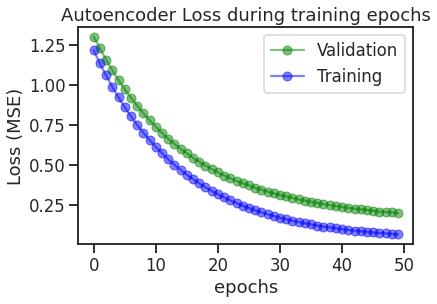

In [26]:
plt.plot(hist_val, c = 'g', label = "Validation", marker = 'o', alpha = 0.5)
plt.plot(hist_tra, c = 'b', label = "Training", marker = 'o', alpha = 0.5)
plt.title("Autoencoder Loss during training epochs")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Loss (MSE)')
plt.show()

Encode training and validation samples by using the Encoder function to obtain its projection on the latent space.

In [27]:
xlat_tr = encoder_val.predict(xtr)
xlat_te = encoder_val.predict(xte)

Visualize the training samples by class (1 or -1) in the latent space.

## **Variational Autoencoder**

In [21]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim), mean = 0.0, stddev = 1)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class KLDivergence_Layer(layers.Layer):


    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergence_Layer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = 0.1*(- .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1))

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


In [22]:
def vae_arch_0(encoding_dim, epochs, bachs, l1_reg, l2_reg, lrate, xtr, xte): 
    earlstop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  mode='auto', baseline=None, restore_best_weights=False, verbose=1)
    rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='auto')
    
    ################### Optimizer ###################
    optim = keras.optimizers.Adam(lr=lrate)

    ################### ENCODER #####################
    
    # 00) INPUT
    x_in = Input(shape=(xtr.shape[1],))    
    # 01) DENSE LAYER
    encode_i = Dense(200, kernel_regularizer=regularizers.l2(l2_reg), activation = 'relu')(x_in)
    # 02) BATCH NORM
    bn_i = BatchNormalization()(encode_i)
    # 03) DENSE LAYER
    encode_ii = Dense(100, activation = 'relu')(bn_i)

    ################## VARIATIONAL TERM #############
    z_mu = Dense(encoding_dim, kernel_regularizer = regularizers.l2(l2_reg), activation = 'relu')(encode_ii)
    z_log_var = Dense(encoding_dim, kernel_regularizer = regularizers.l2(l2_reg), activation = 'relu')(encode_ii)

    ## z_mu + z_log_var
    z_mu, z_log_var = KLDivergence_Layer()([z_mu, z_log_var])
    z_sampling = Sampling(name = 'encoder_output')([z_mu, z_log_var])
    z = Dense(encoding_dim, 'linear')(z_sampling)    

    ################## DECODER #####################
    z_in = Input(shape=(encoding_dim, ))

    decode_i = Dense(100, activation = 'relu')(z_in)
    decode_ii = Dense(200,activation='relu')(decode_i)
    decode_iii = Dense(xtr.shape[1],activation='linear')(decode_ii)
    
    # define Variational AUTOENCODER
    vae = tf.keras.models.Model(x_in, decoder(encoder(x_in)), name="VAE")
    vae.summary()

    # define encoder
    encoder = keras.Model(inputs=x_in, outputs = z, name="encoder_model")
    encoder.summary()

    # define decoder
    decoder = Model(inputs = z_in, outputs = decode_iii, name="decoder")
    decoder.summary()

    ################## COMPILE AND FIT MODEL #############
    vae.compile(optimizer=optim, loss='mse')
    vae.fit(xtr, xtr,epochs=epochs, batch_size=bachs,  shuffle=True,  validation_data=(xte, xte), callbacks = [earlstop, rlrop])
    
    histval = vae.history.history['val_loss']
    histtra = vae.history.history['loss']
    
    return encoder,decoder, vae, histtra, histval

In [23]:

vae_enc, vae_dec, vae, histtra, histval = vae_arch_0(50, 50, 32, 0.001, 0.003, 0.0001, xtr, xte)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1026)]       0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 200)          205400      input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200)          800         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 100)          20100       batch_normalization_1[0][0]      
______________________________________________________________________________________

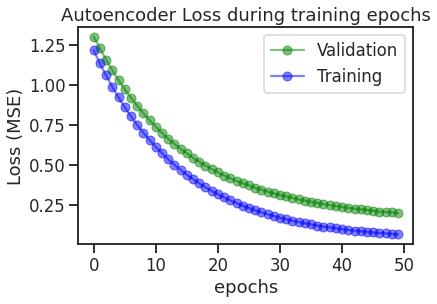

In [28]:
plt.plot(hist_val, c = 'g', label = "Validation", marker = 'o', alpha = 0.5)
plt.plot(hist_tra, c = 'b', label = "Training", marker = 'o', alpha = 0.5)
plt.title("Autoencoder Loss during training epochs")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Loss (MSE)')
plt.show()

In [24]:
vae_enc

In [30]:
xtr_vae = vae_enc.predict(xtr)
xte_vae = vae_enc.predict(xte)

# Visualize 

In [31]:
xtr_ae_tsne = TSNE(n_components=2).fit_transform(xlat_tr)
xtr_kpca_tsne = TSNE(n_components=2).fit_transform(xtr_kpca)
xtr_pca_tsne = TSNE(n_components=2).fit_transform(xtr_pca)
xtr_vae_tsne = TSNE(n_components=2).fit_transform(xtr_vae)

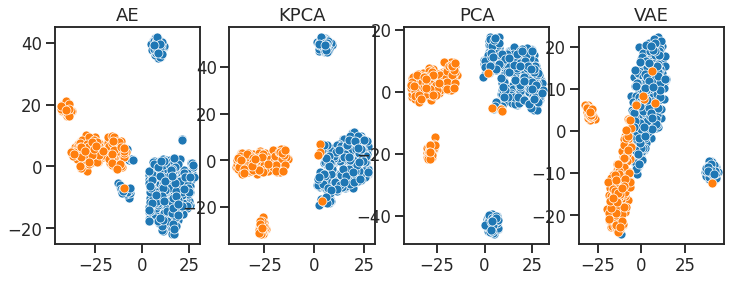

In [32]:
f, ax = plt.subplots(1,4)
f.set_size_inches(12,4)
sns.scatterplot(x = xtr_ae_tsne[(ytr).ravel() == -1,0], y = xtr_ae_tsne[ytr.ravel() == -1,1], ax= ax[0])
sns.scatterplot(x = xtr_ae_tsne[ytr.ravel() == 1,0], y = xtr_ae_tsne[ytr.ravel() == 1,1], ax= ax[0])
ax[0].set_title("AE")
sns.scatterplot(x = xtr_kpca_tsne[(ytr).ravel() == -1,0], y = xtr_kpca_tsne[ytr.ravel() == -1,1], ax= ax[1])
sns.scatterplot(x = xtr_kpca_tsne[ytr.ravel() == 1,0], y = xtr_kpca_tsne[ytr.ravel() == 1,1], ax= ax[1])
ax[1].set_title("KPCA")
sns.scatterplot(x = xtr_pca_tsne[(ytr).ravel() == -1,0], y = xtr_pca_tsne[ytr.ravel() == -1,1], ax= ax[2])
sns.scatterplot(x = xtr_pca_tsne[ytr.ravel() == 1,0], y = xtr_pca_tsne[ytr.ravel() == 1,1], ax= ax[2])
ax[2].set_title("PCA")
sns.scatterplot(x = xtr_vae_tsne[(ytr).ravel() == -1,0], y = xtr_vae_tsne[ytr.ravel() == -1,1], ax= ax[3])
sns.scatterplot(x = xtr_vae_tsne[ytr.ravel() == 1,0], y = xtr_vae_tsne[ytr.ravel() == 1,1], ax= ax[3])
ax[3].set_title("VAE")
plt.show()